In [8]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [9]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [10]:
import os
import pandas as pd

BASOPHIL_dirs = [r'/kaggle/input/white-blood-cell-1/wbc v4 no augmentation/Basophil']

EOSINOPHIL_dirs = [
    r'/kaggle/input/white-blood-cell-1/wbc v4 no augmentation/Eosinophil'
]

LYMPHOCYTE_dir = [ r'/kaggle/input/white-blood-cell-1/wbc v4 no augmentation/Lymphocyte']

MONOCYTE_dirs = [
    r'/kaggle/input/white-blood-cell-1/wbc v4 no augmentation/Monocyte'
]

NEUTROPHIL_dirs = [
    r'/kaggle/input/white-blood-cell-1/wbc v4 no augmentation/Neutrophil'
]

filepaths = []
labels = []
dict_lists = [BASOPHIL_dirs, EOSINOPHIL_dirs, LYMPHOCYTE_dir, MONOCYTE_dirs, NEUTROPHIL_dirs]
class_labels = ['BASOPHIL','EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
bloodCell_data = pd.concat([Fseries, Lseries], axis=1)
bloodCell_df = pd.DataFrame(bloodCell_data)
print(bloodCell_df.head())
print(bloodCell_df["labels"].value_counts())

                                           filepaths    labels
0  /kaggle/input/white-blood-cell-1/wbc v4 no aug...  BASOPHIL
1  /kaggle/input/white-blood-cell-1/wbc v4 no aug...  BASOPHIL
2  /kaggle/input/white-blood-cell-1/wbc v4 no aug...  BASOPHIL
3  /kaggle/input/white-blood-cell-1/wbc v4 no aug...  BASOPHIL
4  /kaggle/input/white-blood-cell-1/wbc v4 no aug...  BASOPHIL
labels
NEUTROPHIL    6231
LYMPHOCYTE    2427
EOSINOPHIL    1066
MONOCYTE       795
BASOPHIL       301
Name: count, dtype: int64


In [11]:
bloodCell_df.shape

(10820, 2)

In [12]:
train_images, test_images = train_test_split(bloodCell_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(bloodCell_df, test_size=0.2, random_state=42)

In [13]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(8656, 2)
(3246, 2)
(2164, 2)
(7574, 2)


In [14]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=8,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=8,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=8,
                                    shuffle=False
                                   )

Found 8656 validated image filenames belonging to 5 classes.
Found 3246 validated image filenames belonging to 5 classes.
Found 2164 validated image filenames belonging to 5 classes.


In [15]:
classes=list(train.class_indices.keys())
print (classes)

['BASOPHIL', 'EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


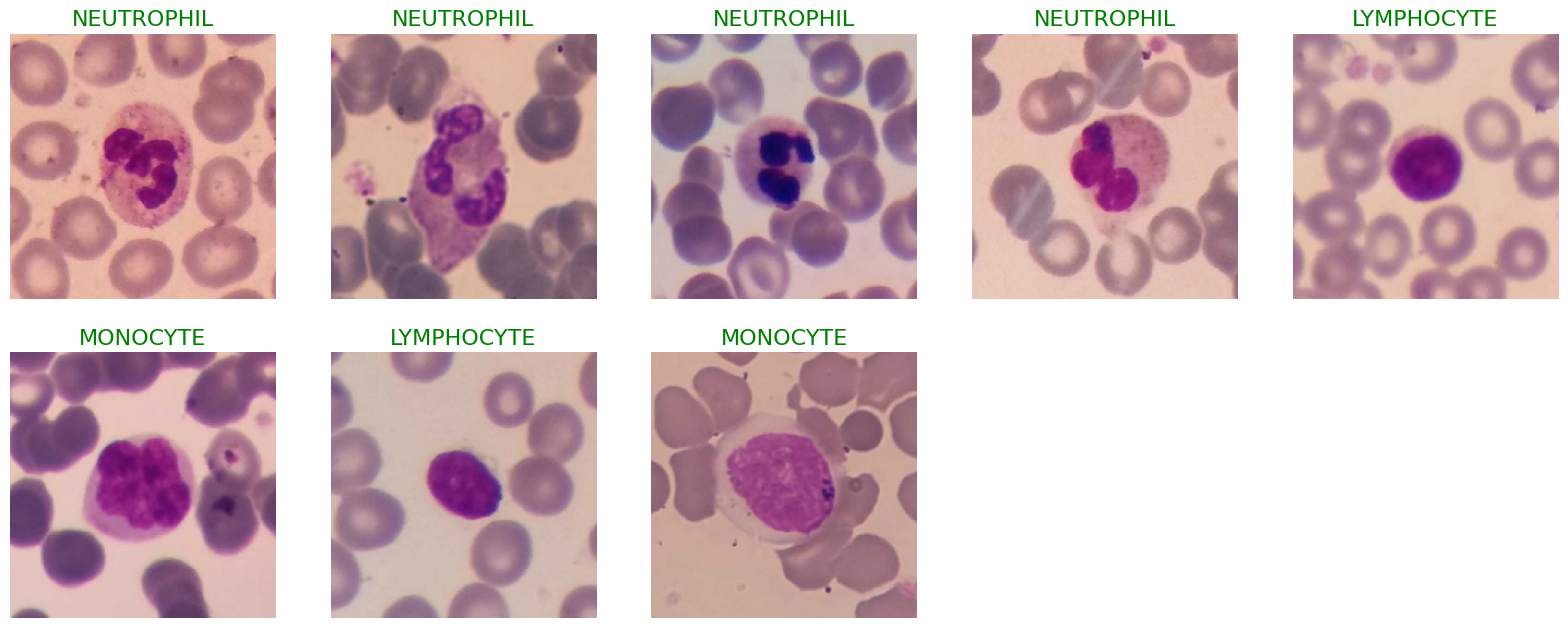

In [16]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
show_knee_images(train)

In [17]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 73, 73, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 73, 73, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 6, 6, 512)      │         2,04

 Total params: 15,612,549 (59.56 MB)

 Trainable params: 15,606,149 (59.53 MB)

 Non-trainable params: 6,400 (25.00 KB)

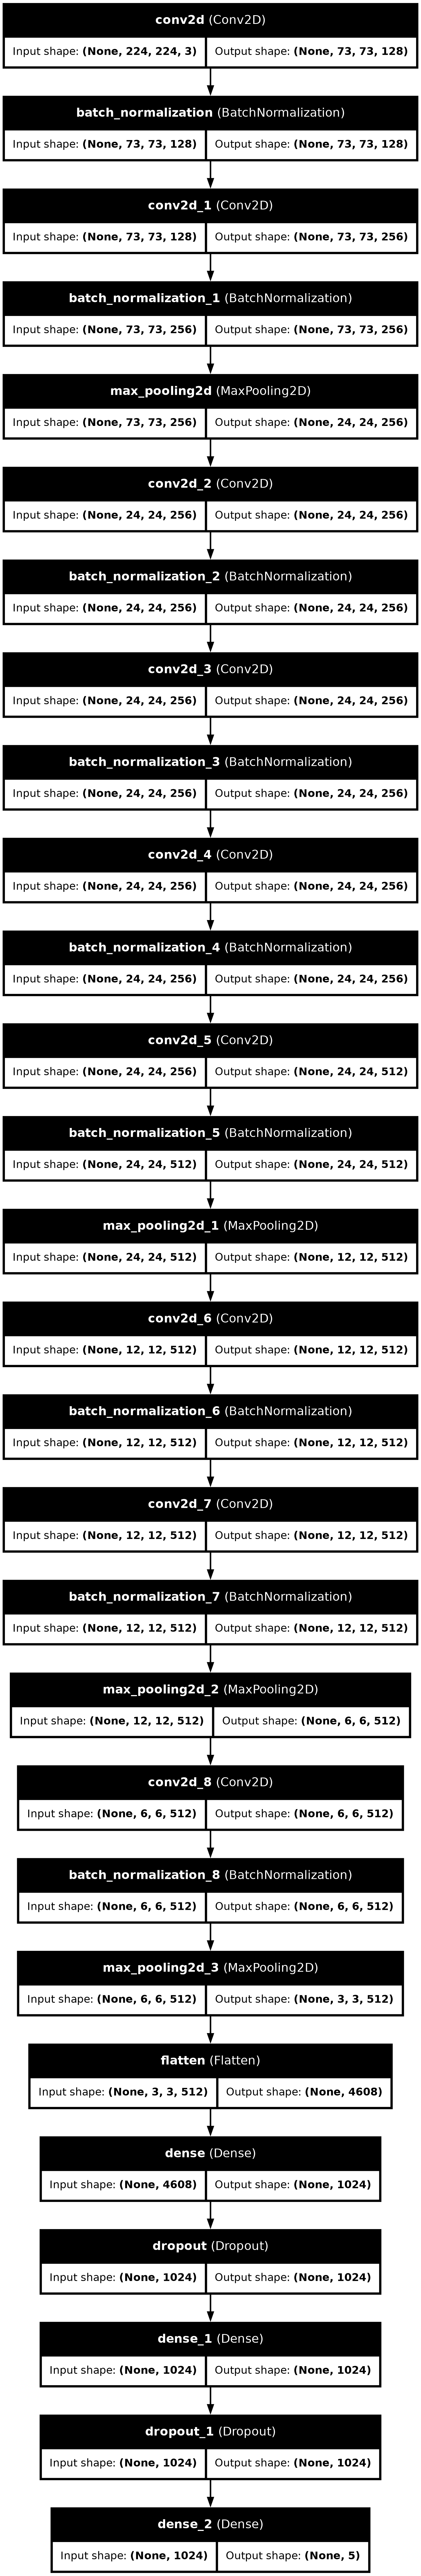

In [18]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [19]:
history = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10


I0000 00:00:1733810352.935372      95 service.cc:145] XLA service 0x780df4013bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733810352.935436      95 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   3/1082 ━━━━━━━━━━━━━━━━━━━━ 50s 46ms/step - accuracy: 0.2153 - loss: 3.5982   

I0000 00:00:1733810362.452422      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1082/1082 ━━━━━━━━━━━━━━━━━━━━ 74s 57ms/step - accuracy: 0.6673 - loss: 1.0528 - val_accuracy: 0.8951 - val_loss: 0.2910
Epoch 2/10
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 43s 40ms/step - accuracy: 0.8689 - loss: 0.3513 - val_accuracy: 0.9288 - val_loss: 0.1906
Epoch 3/10
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 43s 40ms/step - accuracy: 0.9247 - loss: 0.2194 - val_accuracy: 0.9316 - val_loss: 0.1968
Epoch 4/10
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 43s 40ms/step - accuracy: 0.9444 - loss: 0.1549 - val_accuracy: 0.9492 - val_loss: 0.1487
Epoch 5/10
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 43s 40ms/step - accuracy: 0.9645 - loss: 0.1069 - val_accuracy: 0.9552 - val_loss: 0.1286
Epoch 6/10
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 43s 40ms/step - accuracy: 0.9708 - loss: 0.0856 - val_accuracy: 0.9621 - val_loss: 0.1031
Epoch 7/10
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 43s 40ms/step - accuracy: 0.9801 - loss: 0.0586 - val_accuracy: 0.9589 - val_loss: 0.1329
Epoch 8/10
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 43s 40ms/step - accuracy: 0.9851 - loss: 0.04

In [20]:
history1 = model.fit(train, epochs=1, validation_data=val, verbose=1)

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 43s 40ms/step - accuracy: 0.9954 - loss: 0.0179 - val_accuracy: 0.9723 - val_loss: 0.0912


In [21]:
model.evaluate(test, verbose=1)

406/406 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.9728 - loss: 0.0789


[0.0627683624625206, 0.9808995723724365]

In [22]:
model.save("Blood Cell.h5")

In [23]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

406/406 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step


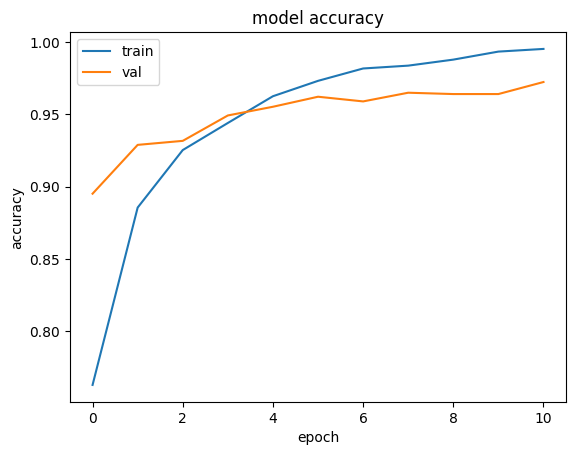

In [24]:
plt.plot(history.history['accuracy'] + history1.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

    BASOPHIL       0.94      1.00      0.97        81
  EOSINOPHIL       0.98      0.95      0.96       339
  LYMPHOCYTE       0.99      0.97      0.98       728
    MONOCYTE       0.91      0.97      0.94       256
  NEUTROPHIL       0.99      0.99      0.99      1842

    accuracy                           0.98      3246
   macro avg       0.96      0.98      0.97      3246
weighted avg       0.98      0.98      0.98      3246

Accuracy of the Model: 98.1%


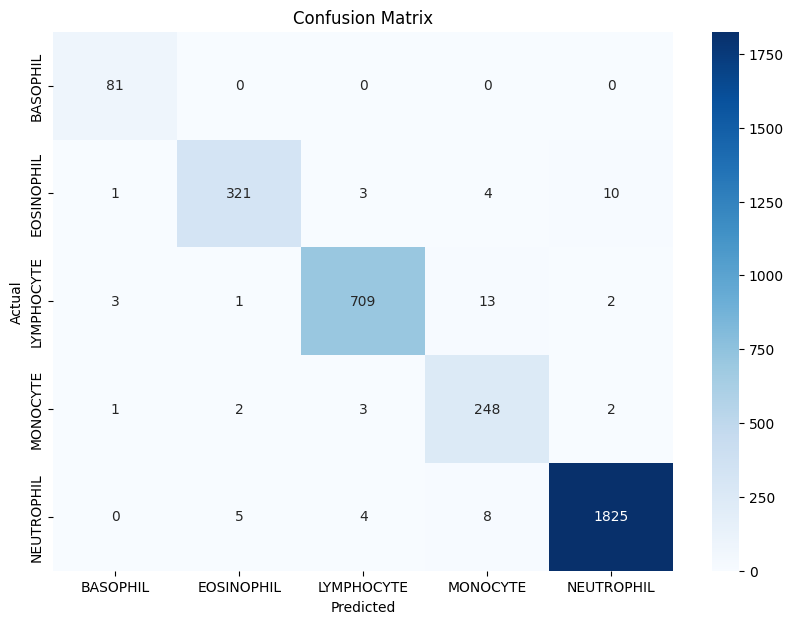

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['BASOPHIL','EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5,4.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5,4.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()